In [7]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

Initialize Important variables used when training our keras CNN

EPOCHS 
INIT_LR:The initial learning rate — a value of 1e-3 is the default value for the Adam optimizer, the optimizer we will be using to train the network.

BS for BatchSize:We will be passing batches of images into our network for training. There are multiple batches per epoch. The BS value controls the batch size.

default_image_size=our defualt images have been processed to be 224 x 224 x 3 dimensions
image_size =initializing image size
directory_root = initializing directory root unot kaggle platform
width= initialization of image width
height=initialization of image height
depth=initialization of RGB channel grades for coloured images

In [8]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((224,224))
image_size = 0
directory_root = '../input/birdspecies'
width = 224
height = 224
depth = 3

Fucntion to Convert images to array

In [9]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image,default_image_size)
            return img_to_array(image)
        else :
            np.array([])
    except Exception as e : 
        print (f"ERROR : {e}")
        return None
    

Fetch Images from Directory into image_list and label_list arrays since its already a cleaned image dataset. only thing we need to do is handly any .ds file which might have been created in the dataset for Mac OS products

In [10]:
image_list, label_list =[],[]
try :
    print("INFO:Loading Images.....")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        #Remove .DS Store file from list if any
        if directory == ".DS Store" :
            root_directory.remove(directory)
     
    for bird_folder in root_dir :
        bird_species_folder_list = listdir(f"{directory_root}/{bird_folder}")
        
        for species_folder in bird_species_folder_list :
            # remove .DS_Store from list
            if species_folder == ".DS_Store" :
                bird_species_folder_list.remove(species_folder)
        
        
        
        for bird_species_folder in bird_species_folder_list:
            print(f"[INFO] Processing {bird_species_folder} ...")
            bird_species_image_list = listdir(f"{directory_root}/{bird_folder}/{bird_species_folder}/")
                
            for single_bird_species_image in bird_species_image_list :
                if single_bird_species_image == ".DS_Store" :
                    bird_species_image_list.remove(single_bird_species_image)

            for image in bird_species_image_list[:200]:
                image_directory = f"{directory_root}/{bird_folder}/{bird_species_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(bird_species_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

INFO:Loading Images.....
[INFO] Processing AMERICAN KESTREL ...
[INFO] Processing AMERICAN GOLDFINCH ...
[INFO] Processing AMERICAN PIPIT ...
[INFO] Processing ALBATROSS ...
[INFO] Processing AMERICAN BITTERN ...
[INFO] Processing AMERICAN COOT ...
[INFO] Processing ARARIPE MANAKIN ...
[INFO] Processing ANHINGA ...
[INFO] Processing AFRICAN FIREFINCH ...
[INFO] Processing ANTBIRD ...
[INFO] Processing ALEXANDRINE PARAKEET ...
[INFO] Processing ANNAS HUMMINGBIRD ...
[INFO] Processing AMERICAN AVOCET ...
[INFO] Processing AFRICAN CROWNED CRANE ...
[INFO] Processing ASIAN CRESTED IBIS ...
[INFO] Processing AMERICAN REDSTART ...
[INFO] Image loading completed


Get size of processed images

In [11]:
image_size = len(image_list)
print(image_size)

2411


Since the image labels are also important to our model,we transform them using Scikit Learn's Label Binarizer

In [12]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [13]:
print(n_classes)
print(label_binarizer.classes_)

16
['AFRICAN CROWNED CRANE' 'AFRICAN FIREFINCH' 'ALBATROSS'
 'ALEXANDRINE PARAKEET' 'AMERICAN AVOCET' 'AMERICAN BITTERN'
 'AMERICAN COOT' 'AMERICAN GOLDFINCH' 'AMERICAN KESTREL' 'AMERICAN PIPIT'
 'AMERICAN REDSTART' 'ANHINGA' 'ANNAS HUMMINGBIRD' 'ANTBIRD'
 'ARARIPE MANAKIN' 'ASIAN CRESTED IBIS']


Using numpy to read image list as an array for the the CNN to handle.

In [14]:
np_image_list = np.array(image_list,dtype=np.float16) / 225.0
print(np_image_list.shape)
print(np_image_list.size)
print(np_image_list.ndim)

(2411, 224, 224, 3)
362923008
4


Splitting dataset into ratioed training validation and test 

In [15]:
print("[INFO] Spliting data to train,validation and  test")
train_ratio = 0.8
val_ratio = 0.1
test_ratio = 0.1
x_remaining, x_test, y_remaining, y_test = train_test_split( np_image_list, image_labels, test_size=test_ratio)
print("Testing Datatset: ",x_test.shape,y_test.shape)
ratio_remaining = 1 - test_ratio
ratio_val_adjusted = val_ratio / ratio_remaining
x_train, x_val, y_train, y_val = train_test_split( x_remaining, y_remaining, test_size=ratio_val_adjusted)
print("Training dataset: ",x_train.shape,y_train.shape)
print("Validation dataset: ",x_val.shape,y_val.shape)














[INFO] Spliting data to train,validation and  test
Testing Datatset:  (242, 224, 224, 3) (242, 16)
Training dataset:  (1927, 224, 224, 3) (1927, 16)
Validation dataset:  (242, 224, 224, 3) (242, 16)


Creating the custom model: Sequential approach is taken. Reference: https://www.tensorflow.org/guide/keras/sequential_model

In [16]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

Display custom model shape

In [17]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 224, 224, 32)      896       
_________________________________________________________________
activation (Activation)      (None, 224, 224, 32)      0         
_________________________________________________________________
batch_normalization (BatchNo (None, 224, 224, 32)      128       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 74, 74, 32)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 74, 74, 64)        18496     
_________________________________________________________________
activation_1 (Activation)    (None, 74, 74, 64)        0

Specifying Optimizer and starting the traing sessions

In [18]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("INFO: training network...")

INFO: training network...


In [19]:
print("Fit model on training data")
history = model.fit(
    x_train,
    y_train,
    batch_size=BS,
    epochs=EPOCHS,
    steps_per_epoch=len(x_train) // BS,
    # We pass some validation for
    # monitoring validation loss and metrics
    # at the end of each epoch
    validation_data=(x_val, y_val),verbose=1
  )

Fit model on training data
Epoch 1/25
60/60 [==============================] - 20s 231ms/step - loss: 0.8289 - accuracy: 0.1407 - val_loss: 0.6655 - val_accuracy: 0.0702
Epoch 2/25
60/60 [==============================] - 13s 213ms/step - loss: 0.4092 - accuracy: 0.2816 - val_loss: 0.3778 - val_accuracy: 0.0620
Epoch 3/25
60/60 [==============================] - 13s 211ms/step - loss: 0.2474 - accuracy: 0.3315 - val_loss: 0.5300 - val_accuracy: 0.0785
Epoch 4/25
60/60 [==============================] - 13s 209ms/step - loss: 0.2088 - accuracy: 0.4534 - val_loss: 0.2669 - val_accuracy: 0.1281
Epoch 5/25
60/60 [==============================] - 13s 209ms/step - loss: 0.1599 - accuracy: 0.5887 - val_loss: 0.2507 - val_accuracy: 0.2355
Epoch 6/25
60/60 [==============================] - 13s 210ms/step - loss: 0.1318 - accuracy: 0.6870 - val_loss: 0.2492 - val_accuracy: 0.2603
Epoch 7/25
60/60 [==============================] - 12s 209ms/step - loss: 0.1130 - accuracy: 0.7473 - val_loss: 0.

In [20]:
history.history

{'loss': [0.6983212232589722,
  0.34602442383766174,
  0.25239863991737366,
  0.19395042955875397,
  0.15154299139976501,
  0.13082581758499146,
  0.11352670937776566,
  0.09933283925056458,
  0.07666844874620438,
  0.06681222468614578,
  0.05381200462579727,
  0.04876108467578888,
  0.04884541407227516,
  0.03878223896026611,
  0.03158191964030266,
  0.026412058621644974,
  0.04368323087692261,
  0.03630198910832405,
  0.029184674844145775,
  0.021927151829004288,
  0.018088961020112038,
  0.013160697184503078,
  0.00979643128812313,
  0.010212755762040615,
  0.010328658856451511],
 'accuracy': [0.16302083432674408,
  0.27598944306373596,
  0.3160949945449829,
  0.480211079120636,
  0.6248021125793457,
  0.6839050054550171,
  0.7514511942863464,
  0.7788918018341064,
  0.8501319289207458,
  0.8802110552787781,
  0.920844316482544,
  0.9313983917236328,
  0.9271767735481262,
  0.9567282199859619,
  0.9635884165763855,
  0.9778364300727844,
  0.9255936741828918,
  0.9551451206207275,
  

Plotting the data to gain insights on both training and validation loss and accuracy

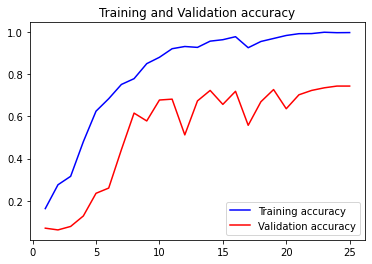

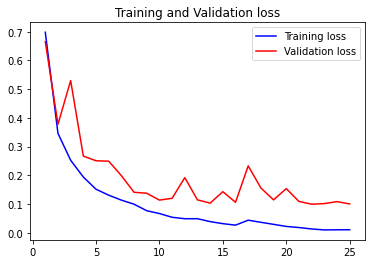

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation accuracy')
plt.title('Training and Validation accuracy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

WHAT INSIGHTS CAN WE GAIN FROM THESE GRAPHS?